In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from src.data.datamatrices import DataMatrices
from config import config
_matrix = DataMatrices.create_from_config(config)

In [3]:
class CNN(nn.Module):
    def __init__(self, in_features, rows, cols, device = torch.device("cpu")):
        super(CNN, self).__init__()

        out1 = 2
        out2 = 20
        kernel1 = (1,3)
        kernel2 = (1,cols-2) # cols - (kernel1[1] - 1)

        self.conv1 = nn.Conv2d(in_features, out1, kernel1)
        self.conv2 = nn.Conv2d(out1, out2, kernel2)
        self.votes = nn.Conv2d(out2+1, 1, (1,1)) # input features is out2 plus the appended last_weights
        
        # BTC bias
        b = torch.zeros((1,1))
        self.b = nn.Parameter(b)

    def forward(self, x, w):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.cat((x,w),dim=1)
        x = self.votes(x)
        x = torch.squeeze(x)
        
        cash = self.b.repeat(x.size()[0], 1)
        
        x = torch.cat((cash, x), dim=1)
        x = F.softmax(x, dim=1)
        
        return x

In [21]:
def loss_func(output, future_price, input_no):
    #r_t = log(mu_t * y_t dot w_{t-1})
    future_w = (future_price * output) / torch.sum(future_price * output, dim=1)[:, None]
    pv_vector = torch.sum(output * future_price, dim=1) * (torch.cat([torch.ones(1), pure_pc(output, input_no, future_w)], dim=0))
    return -torch.mean(torch.log(pv_vector))

def pure_pc(output, input_no, future_w):
    c = config["trading"]["trading_consumption"]
    w_t = future_w[:input_no-1]  # rebalanced
    w_t1 = output[1:input_no]
    mu = 1 - torch.sum(torch.abs(w_t1[:, 1:]-w_t[:, 1:]), dim=1)*c
    return mu

In [22]:
def batch():
    batch = _matrix.next_batch()
    w = torch.tensor(batch['last_w'])
    w = w[:, None, : , None] # Concat along dim=1, the features dim)
    X = torch.tensor(batch['X'])
    y = torch.tensor(batch['y'])
    return X, w, y, batch['setw']

In [23]:
model = CNN(config["input"]["feature_no"],
            config["input"]["coin_no"],
           config["input"]["window_size"])
training = _matrix.get_training_set()
w = torch.tensor(training['last_w'])
w_train = w[:, None, : , None] # Concat along dim=1, the features dim)
X_train = torch.tensor(training['X'])
y_train = torch.tensor(training['y'])
input_no_train = y_train.shape[0]
future_price_train = torch.cat([torch.ones((input_no_train, 1)), y_train[:, 0, :]], dim=1)

100%|██████████| 100000/100000 [14:17<00:00, 116.58it/s]


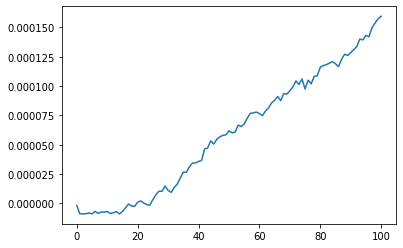

In [24]:
learning_rate = 0.00028
# optimizer = torch.optim.Adam([
#         {'params': model.parameters()},
#         {'params': model.b}
# ], lr=learning_rate)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for i in (t:=trange(100000)):
    X, w, y, setw = batch()
    X = X / X[:, 0, None, :, -1, None]
    input_no = y.shape[0]
    future_price = torch.cat([torch.ones((input_no, 1)), y[:, 0, :]], dim=1) # Add cash price (always 1)
    
    output = model(X, w)
    loss = loss_func(output, future_price, input_no)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%999==0:
        out = model(X_train, w_train)
        losses.append(loss_func(out, future_price_train, input_no_train))
    setw(output[:, 1:].detach().numpy())

plot(losses)